In [1]:
#Cavity Antiresonance example using Index
#This file is for testing

In [2]:
using QuantumOptics
using OrdinaryDiffEq
using ModelingToolkit
using LinearAlgebra
using Symbolics
using SymbolicUtils
using DifferentialEquations
using Plots

In [4]:
include("../../src/indexing.jl")
include("../../src/doubleSums.jl")
include("../../src/averageSums.jl")
include("../../src/indexedMeanfield.jl")

isNotIn (generic function with 1 method)

In [ ]:
order = 2
@cnumbers Δc η Δa κ

N = 2 #number of atoms
hc = FockSpace(:cavity)
ha = NLevelSpace(Symbol(:atom),2)
h = hc ⊗ ha

#define indices
i_ind = Index(h,:i,N)
j_ind = Index(h,:j,N)
k_ind = Index(h,:k,N)

#define indexed variables
g(k) = IndexedVariable(:g,k)
Γ_ij = DoubleIndexedVariable(:Γ,i_ind,j_ind,true)
Ω_ij = DoubleIndexedVariable(:Ω,i_ind,j_ind,false)

@qnumbers a::Destroy(h)
σ(i,j,k) = IndexedOperator(Transition(h,:σ,i,j),k)

σ (generic function with 1 method)

In [ ]:
# Hamiltonian
Hc = Δc*a'a + η*(a' + a)
#Ha = Δa*sum(σ(2,2,k) for k=1:N) + sum(Ω(i,j)*σ(2,1,i)*σ(1,2,j)*(i≠j) for i=1:N for j=1:N)
Ha = Δa*IndexedSingleSum(σ(2,2,i_ind),i_ind) + IndexedDoubleSum(Ω_ij*σ(2,1,i_ind)*σ(1,2,j_ind),i_ind,j_ind,true)
#Hi = sum(g(k)*(a'σ(1,2,k) + a*σ(2,1,k)) for k=1:N)
Hi = IndexedSingleSum(g(i_ind)*(a'*σ(1,2,i_ind) + a*σ(2,1,i_ind)),i_ind)
H = Hc + Ha + Hi

(η*(a′)+η*(a)+Δc*(a′*a)+Σ(i=1:10)Δa*(σ22i)+Σ(i=1:10)Σ(j=1:10)(j≠i)Ωij*(σ12j*σ21i)+Σ(i=1:10)gi*(a′*σ12i)+Σ(i=1:10)gi*(a*σ21i))

In [ ]:
# Jump operators & and rates
#J = [a, [σ(1,2,k) for k=1:N]]
J = [a, [σ(1,2,i_ind),σ(1,2,j_ind)] ] 
#rates = [κ, [Γ(i,j) for i=1:N, j=1:N]]
#rates = [κ,Γ_ij]
rates = [κ,Γ_ij]

2-element Vector{Sym{Parameter}}:
 κ
 Γij

In [ ]:
ops = [a, σ(2,2,k_ind), σ(1,2,k_ind)]
eqs = indexedMeanfield(ops,H,J;rates=rates,order=order)

∂ₜ(⟨a⟩) = (0 - 1im)*η + (0 - 1im)*var"∑(i=1:10)gi*⟨σ12i⟩" + (0 - 1im)*Δc*⟨a⟩ - 0.5κ*⟨a⟩
∂ₜ(⟨σ22k⟩) = (0 + 1im)*var"∑(i=1:10)(i≠k)Ωik*⟨σ21i*σ12k⟩" + (0 - 1im)*var"∑(j=1:10)(j≠i,k)Ωkj*⟨σ12j*σ21k⟩" + (0 + 1im)*gk*⟨a′*σ12k⟩ + (0 - 1im)*gk*⟨a*σ21k⟩ - 0.5var"∑(i=1:10)(i≠j,k)Γik*⟨σ21i*σ12k⟩" - 0.5var"∑(j=1:10)(j≠k)Γkj*⟨σ12j*σ21k⟩" - Γkk*⟨σ22k⟩
∂ₜ(⟨σ12k⟩) = var"∑(j=1:10)(j≠k)Γkj*⟨σ12j*σ22k⟩" + (0 - 1im)*var"∑(j=1:10)(j≠i,k)Ωkj*⟨σ12j⟩" + (0 + 2im)*var"∑(j=1:10)(j≠i,k)Ωkj*⟨σ12j*σ22k⟩" + (0 - 1im)*gk*⟨a⟩ + (0 - 1im)*Δa*⟨σ12k⟩ + (0 + 2im)*gk*⟨a*σ22k⟩ - 0.5var"∑(j=1:10)Γkj*⟨σ12j⟩"


In [ ]:
eqs_comp = indexedComplete(eqs)
1

1

In [ ]:
eqs_ = evalME(eqs_comp)
1

1

In [ ]:
u0 = zeros(ComplexF64, length(eqs_))
# parameter
Γ_ = 1.0
d = 2π*0.08 #0.08λ
θ = π/2

Ωij_(i,j) = Γ_*(-3/4)*( (1-(cos(θ))^2)*cos(d)/d-(1-3*(cos(θ))^2)*(sin(d)/(d^2)+(cos(d)/(d^3))) )
function Γij_(i,j)
    i==j ? Γ_ : Γ_*(3/2)*( (1-(cos(θ))^2)*sin(d)/d+(1-3*(cos(θ))^2)*((cos(d)/(d^2))-(sin(d)/(d^3))))
end

ΓMatrix = [Γij_(i,j) for i = 1:N, j=1:N]
ΩMatrix = [Ωij_(i,j) for i = 1:N, j=1:N]

g_ = 2Γ_
κ_ = 20Γ_
Δa_ = 0Γ_
Δc_ = 0Γ_
η_ = κ_/100

g_v = [g_*(-1)^j for j=1:j_ind.rangeN] 

valMap1 = createValueMap(g(j_ind),g_v)
valMap2 = createValueMap(Γ_ij,ΓMatrix)
valMap3 = createValueMap(Ω_ij,ΩMatrix)
valMap = collect(merge(valMap1,valMap2,valMap3))

@named sys = ODESystem(eqs_)

Model sys with 278 equations
States (278):
  var"⟨a⟩"(t)
  var"⟨σ221⟩"(t)
  var"⟨σ222⟩"(t)
  var"⟨σ223⟩"(t)
  var"⟨σ224⟩"(t)
  var"⟨σ225⟩"(t)
⋮
Parameters (204):
  g4
  g3
  g6
  Δc
  g8
  g1
⋮

In [ ]:
ps = [Δc, η, Δa, κ]
p0 = [Δc_, η_, Δa_, κ_]

Δ_ls = [-10:0.05:10;]Γ_
n_ls = zeros(length(Δ_ls))

for i=1:length(Δ_ls)
    Δc_i = Δ_ls[i]
    Δa_i = Δc_i + Ωij_(1,2) #cavity on resonace with the shifted collective emitter
    p0_i = [Δc_i, η_, Δa_i, κ_]
    ps_ = vcat(ps.=>p0_i,valMap) #Combine all the parameters + values to one list for solving
    prob = ODEProblem(sys,u0,(0.0, 20Γ_), ps_);
    #prob = ODEProblem(sys,u0,(0.0, 20Γ_), ps.=>p0_i);
    prob_ss = SteadyStateProblem(prob);
    sol_ss = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-8, reltol=1e-8),
        reltol=1e-14, abstol=1e-14, maxiters=5e7)
    n_ls[i] = abs2(sol_ss[a])
end

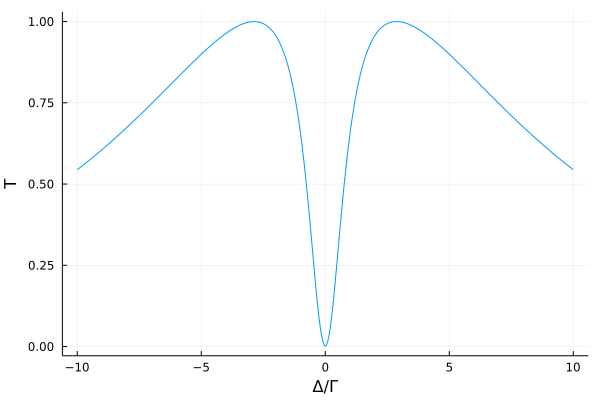

In [ ]:
T = n_ls ./ maximum(n_ls)
plot(Δ_ls, T, xlabel="Δ/Γ", ylabel="T", legend=false)